The following code loads are sample data (in the same folder), computes the Pearson correlation using Pandas and Scipy and plots the median filtered data.

Pandas computed Pearson r: 0.21698505329899312
Scipy computed Pearson r: 0.21698505329899345 and p-value: 2.295680306138547e-10


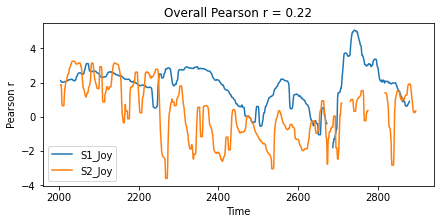

In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv('/content/drive/MyDrive/covid19 (1)/correlation/synchrony_sample.csv')
df=df[2900:2000:-1]
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['S1_Joy'], df.dropna()['S2_Joy'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=10,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Once again, the Overall Pearson r is a measure of global synchrony that reduces the relationship between two signals to a single value. Nonetheless there is a way to look at moment-to-moment, local synchrony, using Pearson correlation. One way to compute this is by measuring the Pearson correlation in a small portion of the signal, and repeat the process along a rolling window until the entire signal is covered. This can be somewhat subjective as it requires arbitrarily defining the window size you’d like to repeat the procedure

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

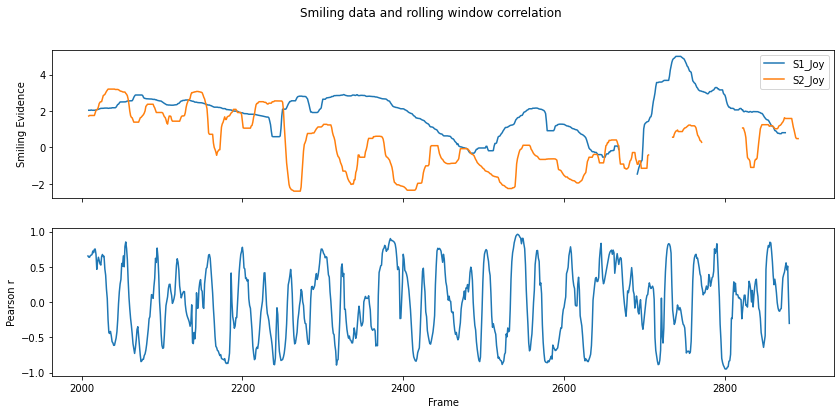

In [12]:
# Set window size to compute moving window synchrony.
r_window_size = 15
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['S1_Joy'].rolling(window=r_window_size, center=True).corr(df_interpolated['S2_Joy'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=18,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")   

The code below implements a cross correlation function using pandas functionality. It can also wrap the data so that the correlation values on the edges are still calculated by adding the data from the other side of the signal.

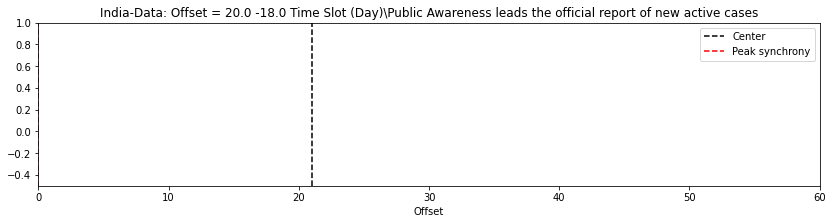

In [13]:
def crosscorr(datax, datay, lag=10, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy'][0:540]
d2 = df['S2_Joy'][540:1080]
seconds = 20
fps = 1
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#ax.set(title=f'UK-Data: Offset = {offset} Time Slot (Day)\Public Awareness leads the official report of new active cases',ylim=[-0.5,1],xlim=[0,60], xlabel='Offset',ylabel='Pearson r')
ax.set(title=f'India-Data: Offset = {offset} -18.0 Time Slot (Day)\Public Awareness leads the official report of new active cases',ylim=[-0.5,1],xlim=[0,60], xlabel='Offset',ylabel='')
#ax.set_xticks([0, 50,100,150,200,250,300])
#ax.set_xticklabels([-150,-100,-50,0,50,100,150]);
plt.legend()

To assess the more fine grained dynamics, we can compute the windowed time lagged cross correlations (WTLCC). This process repeats the time lagged cross correlation in multiple windows of the signal. Then we can analyze each window or take the sum over the windows would provide a score comparing the difference between the leader follower interaction between two individuals.

In [14]:
df.shape[0]/10

90.0

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


[Text(69.0, 0.5, 'Epochs'),
 (0.0, 40.0),
 Text(0.5, 69.0, 'Offset'),
 Text(0.5, 1.0, 'Rolling Windowed Time Lagged Cross Correlation')]

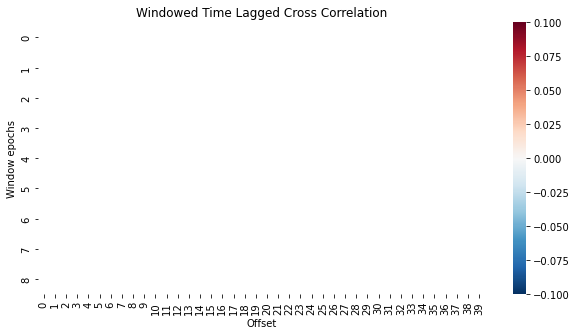

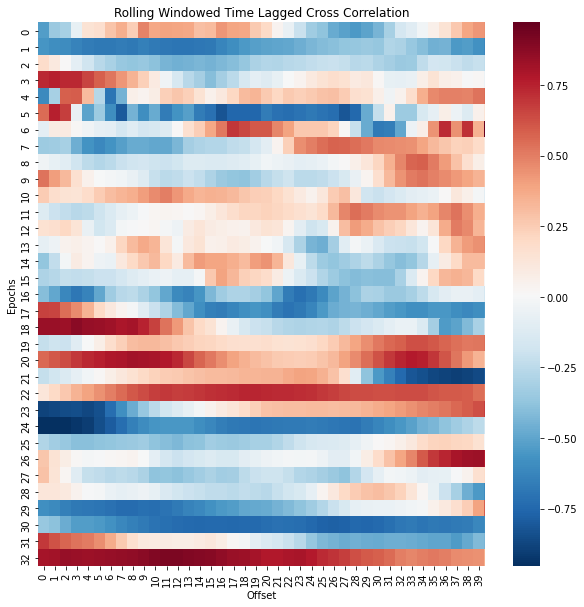

In [15]:
# Windowed time lagged cross correlation
seconds = 20
fps = 1
no_splits = 10
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(1, no_splits):
    d1 = df['S1_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['S2_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,40], xlabel='Offset',ylabel='Window epochs')
#ax.set_xticks([0,50,100,150,200,250,300])
#ax.set_xticklabels([-150,-100,-50,0,50,100,150]);

# Rolling window time lagged cross correlation
seconds = 20
fps = 1
window_size = 54 #samples
t_start = 0
t_end = t_start + window_size
step_size = 15
rss=[]
while t_end < 540:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,40], xlabel='Offset',ylabel='Epochs')
#ax.set_xticks([0,50,100,150,200,250,300])
#ax.set_xticklabels([-150,-100,-50,0,50,100,150]);

In [105]:
rs

[0.5906018844390765,
 0.5367159318797249,
 0.5675673945863693,
 0.5967998051395896,
 0.4536888470257349,
 0.2319055709725133,
 0.08907208330996477,
 -0.027831593258584236,
 -0.0002808177889342008,
 0.009213473975771184,
 0.09156258766329987,
 0.15913512859043003,
 0.2632821891842985,
 0.23138218751851206,
 0.25243290191174106,
 0.34817477691409526,
 0.34864393007633515,
 0.42611583506238565,
 0.40518010218866723,
 0.3486956926765607,
 0.29235420648855126,
 0.24991509119839614,
 0.15606816906570453,
 0.10120825192622403,
 0.06733061780583026,
 -0.023760063241972256,
 -0.047541581195187,
 -0.06136174803202441,
 -0.12781092257344953,
 -0.08008432912996971,
 -0.07153908733650789,
 -0.07374098673937268,
 -0.006509054802501605,
 0.05186101112103343,
 0.09488944478390282,
 0.044596118891332165,
 0.018328858843325052,
 -0.007097557280369942,
 -0.011308505970457563,
 0.008783681457507445,
 -0.02283715705621031]